In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import lambertw
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

# --- MODEL PARAMETERS ---
# Network Topology and Physics
N_NODES = 1000       # Number of interacting agents (nodes)
K = 5                # Node connectivity (degree)
NOISE_SCALE = 1.0    # Scale parameter for exponential demand noise
B_INIT = 2.0         # Initial buffer stock
T_STEPS = 2000       # Total simulation duration (time steps)
T_START = 100        # Warm-up period to discard transient dynamics

# Control Strategy Parameters
ALPHA = 0.3          # Correction gain (response aggressiveness)
EPSILON = 0.02       # Savings rate (drift parameter)
PIPELINE_LEN = 10    # Supply chain delay (lag steps)

# Strategy Configurations
BETA_MYOPIC = 0.0    # Myopic strategy: Ignores supply line (Beta = 0)
BETA_WISE = 1.0      # Wise strategy: Fully compensates for supply line (Beta = 1)

# --- ANALYTICAL THRESHOLD ---
# Calculation of the theoretical critical buffer threshold (Bc).
# Derived from the Mean Field solution: Bc * exp(1 - Bc) = 1/K
# This defines the boundary between stable and unstable regimes (SOC).
BC_THEO = -lambertw(-1/(np.exp(1)*K), k=-1).real

# --- VISUALIZATION SETTINGS ---
# Standardized color palette for publication figures
COLORS = {
    'SIMULATION': '#2E86AB',  # Deep Blue
    'THEORY': '#A23B72',      # Purple/Magenta
    'MYOPIC': '#F18F01',      # Orange
    'WISE': '#73AB84',        # Green
    'GRID': '#E0E0E0',
    'ZERO': '#666666'
}

print(f"--- CONFIGURATION LOADED ---")
print(f"Connectivity (K): {K}")
print(f"Theoretical Critical Threshold (Bc): {BC_THEO:.4f}")
print(f"Correction Gain (Alpha): {ALPHA}")

--- CONFIGURATION LOADED ---
Connectivity (K): 5
Theoretical Critical Threshold (Bc): 3.9943
Correction Gain (Alpha): 0.3


In [2]:
def measure_delay_velocity(B, k, n, T, T_start, noise_scale=1.0):
    """
    Simulates network dynamics with a fixed buffer size B to estimate the
    drift velocity v(B). Used to numerically determine the critical threshold Bc.
    
    Returns:
        float: Mean velocity of delay accumulation. Positive implies instability.
    """
    prev_delays = np.zeros(n)
    v_history = []
    
    for t in range(T):
        # 1. Stochastic Load Generation (Mean Field Approximation)
        # Each node connects to k random neighbors at every step.
        noise = scipy.stats.expon.rvs(scale=noise_scale, size=n)
        
        # Efficient neighbor selection via shuffling
        delays_pool = np.zeros(n * k)
        for i in range(k):
            np.random.shuffle(prev_delays)
            delays_pool[i*n : (i+1)*n] = prev_delays
        neighbor_matrix = np.reshape(delays_pool, (n, k))
        
        # 2. Delay Dynamics
        # Max-Plus algebra: Delay(t) = max(0, max(Neighbor_Delays) + Noise - Buffer)
        incoming_load = np.max(neighbor_matrix, axis=1) + noise
        curr_delays = np.maximum(0, incoming_load - B)
        
        # 3. Velocity Measurement
        if t >= T_start:
            # v = D(t) - D(t-1)
            v_history.append(np.mean(curr_delays - prev_delays))
            
        prev_delays = curr_delays
        
    return np.mean(v_history)


def simulate_supply_chain_dynamics(B_start, k, n, T, T_start, 
                                 epsilon=0.02, alpha=0.3, beta=1.0, 
                                 pipeline_len=5, noise_scale=1.0):
    """
    Simulates the full temporal network with physical delivery delays and 
    adaptive control strategies (SOC).
    
    Parameters:
        beta (float): Strategy parameter. 
                      0.0 = Myopic (ignores supply line).
                      1.0 = Wise (compensates for supply line).
        pipeline_len (int): Physical time delay between ordering and receiving goods.
    """
    # State Initialization
    prev_delays = np.zeros(n)
    buffers = np.full(n, B_start)
    
    # Supply Line Matrix: Rows=Nodes, Cols=Time_Steps_To_Arrival
    # col[0] = Arriving today, col[-1] = New orders placed today
    supply_pipeline = np.zeros((n, pipeline_len))
    
    # Data Recording
    ts_delays = np.zeros(T - T_start)
    ts_buffers = np.zeros(T - T_start)
    
    for t in range(T):
        # --- 1. PHYSICAL LAYER: GOODS RECEIPT ---
        # Goods at head of pipeline are added to local inventory
        arrived_goods = supply_pipeline[:, 0]
        buffers = np.maximum(0, buffers + arrived_goods)
        
        # Time propagation: Shift pipeline left
        supply_pipeline[:, :-1] = supply_pipeline[:, 1:]
        supply_pipeline[:, -1] = 0.0  # Clear slot for new orders
        
        # --- 2. NETWORK LAYER: DEMAND SHOCK ---
        # Generate incoming workload from neighbors (Mean Field)
        noise = scipy.stats.expon.rvs(scale=noise_scale, size=n)
        
        delays_pool = np.zeros(n * k)
        for i in range(k):
            np.random.shuffle(prev_delays)
            delays_pool[i*n : (i+1)*n] = prev_delays
        neighbor_matrix = np.reshape(delays_pool, (n, k))
        
        incoming_load = np.max(neighbor_matrix, axis=1) + noise
        
        # Calculate current network delay (Error signal)
        curr_delays = np.maximum(0, incoming_load - buffers)
        is_congested = curr_delays > 1e-3
        
        # --- 3. CONTROL LAYER: AGENT HEURISTICS ---
        
        # A. Supply Line Estimation
        # Sum of all goods currently in transit for each node
        pending_orders = np.sum(supply_pipeline, axis=1)
        
        # B. Perceived Gap Calculation
        # Wise agents (Beta=1) reduce reaction by considering pending stock.
        perceived_gap = curr_delays - (beta * pending_orders)
        
        # C. Decision Rule (Regime Switching)
        new_orders = np.zeros(n)
        
        # Regime 1: Correction (Delay > 0)
        # Order placement follows Anchor-and-Adjust logic
        needs_correction = (is_congested) & (perceived_gap > 0)
        new_orders[needs_correction] = alpha * perceived_gap[needs_correction]
        
        # Place orders at the tail of the pipeline
        supply_pipeline[needs_correction, -1] = new_orders[needs_correction]
        
        # Regime 2: Optimization (Delay = 0)
        # If performing well, agents slowly reduce buffer (cost cutting)
        buffers[~is_congested] = np.maximum(0, buffers[~is_congested] - epsilon)
        
        # --- 4. DATA LOGGING ---
        if t >= T_start:
            ts_delays[t - T_start] = np.mean(curr_delays)
            ts_buffers[t - T_start] = np.mean(buffers)
            
        prev_delays = curr_delays
        
    return ts_delays, ts_buffers, prev_delays

In [3]:
def plot_static_phase_comparison():
    """
    Comparative Analysis of Static Network Phases.
    
    Visualizes the instantaneous velocity evolution ($v_t$) in two distinct regimes:
    1. Unstable Phase (B < Bc): Positive mean velocity indicates constant delay accumulation.
    2. Stable Phase (B > Bc): Mean velocity near zero indicates a stationary equilibrium.
    """
    print("Generating Static Phase Comparison...")
    
    # Simulation Parameters
    T_TEST = 1000
    B_UNSTABLE = 2.0  # Below Critical Threshold (Accumulation)
    B_STABLE = 5.0    # Above Critical Threshold (Stability)
    
    def simulate_velocity_trace(buffer_val):
        """Runs the static simulation and returns the velocity time series."""
        prev_delays = np.zeros(N_NODES)
        v_history = []
        
        for t in range(T_TEST):
            # Stochastic Load Generation
            noise = scipy.stats.expon.rvs(scale=NOISE_SCALE, size=N_NODES)
            
            # Neighbor Interactions (Mean Field)
            delays_pool = np.zeros(N_NODES * K)
            for i in range(K):
                np.random.shuffle(prev_delays)
                delays_pool[i*N_NODES : (i+1)*N_NODES] = prev_delays
            neighbor_matrix = np.reshape(delays_pool, (N_NODES, K))
            
            incoming_load = np.max(neighbor_matrix, axis=1) + noise
            curr_delays = np.maximum(0, incoming_load - buffer_val)
            
            # Instantaneous Velocity: v(t) = D(t) - D(t-1)
            v_t = np.mean(curr_delays - prev_delays)
            v_history.append(v_t)
            prev_delays = curr_delays
            
        return v_history

    # Execute Simulations
    v_unstable = simulate_velocity_trace(B_UNSTABLE)
    v_stable = simulate_velocity_trace(B_STABLE)

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=120)
    
    # Panel A: Unstable Regime
    axes[0].plot(v_unstable, color='#D62828', linewidth=1, alpha=0.8, 
                 label=f'Unstable Regime ($B={B_UNSTABLE}$)')
    
    mean_unstable = np.mean(v_unstable[100:])
    axes[0].axhline(mean_unstable, color='black', linestyle='--', linewidth=2, 
                    label=f'Mean Drift $\\approx$ {mean_unstable:.2f}')
    
    axes[0].set_title(f"A. Unstable Phase ($B < B_c$): Constant Accumulation", 
                      fontsize=12, fontweight='bold', loc='left')
    axes[0].set_ylabel("Velocity ($v_t$)", fontsize=11)
    axes[0].legend(loc='upper right', frameon=True)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_facecolor('#FFF5F5')  # Light red background for emphasis

    # Panel B: Stable Regime
    axes[1].plot(v_stable, color='#2A9D8F', linewidth=1, alpha=0.8, 
                 label=f'Stable Regime ($B={B_STABLE}$)')
    
    axes[1].axhline(0, color='black', linestyle='--', linewidth=2, 
                    label='Equilibrium ($v=0$)')
    
    axes[1].set_title(f"B. Stable Phase ($B > B_c$): Stationary Equilibrium", 
                      fontsize=12, fontweight='bold', loc='left')
    axes[1].set_xlabel("Time Steps (t)", fontsize=11)
    axes[1].set_ylabel("Velocity ($v_t$)", fontsize=11)
    axes[1].legend(loc='upper right', frameon=True)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_facecolor('#F0FFF4')  # Light green background for emphasis

    plt.tight_layout()
    plt.show()

Generating Static Phase Comparison...


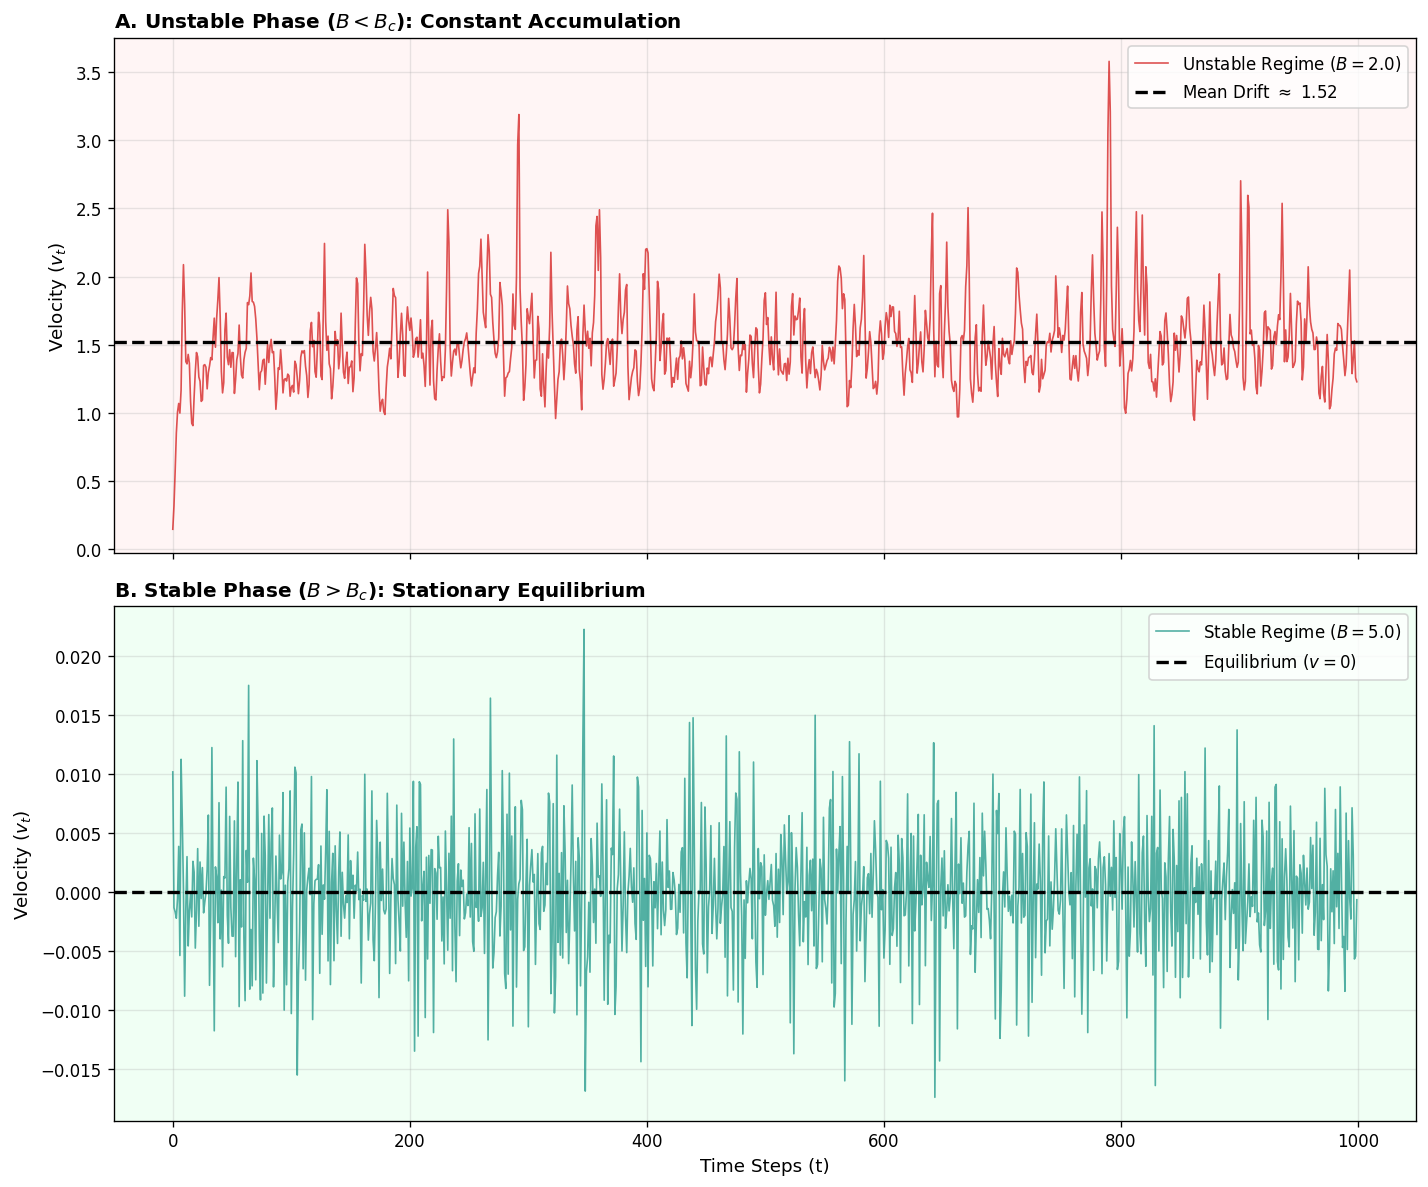

In [4]:
plot_static_phase_comparison()

In [5]:
def plot_velocity_trend_comparison():
    """
    Comparison of Velocity Trends: Static vs. Adaptive (SOC) Systems.
    
    Demonstrates the fundamental difference between a fixed-buffer system (Static)
    and a self-organizing one (SOC). 
    - Static Case: If Buffer < Critical Threshold, velocity remains positive (constant accumulation).
    - SOC Case: The system adapts, bringing velocity back to zero (stability).
    """
    print("Generating Velocity Trend Comparison...")
    
    T_SIM = 1500
    B_LOW = 1.0  # Set below the critical threshold (Bc ~ 4.0) to trigger instability
    WINDOW = 50  # Smoothing window for trend visualization
    
    # --- 1. STATIC SYSTEM SIMULATION (Fixed Buffer) ---
    # Simulates a network that cannot adjust its buffer size.
    def simulate_static_history():
        delays_prev = np.zeros(N_NODES)
        velocity_history = []
        
        for t in range(T_SIM):
            # Stochastic Load
            noise = scipy.stats.expon.rvs(scale=NOISE_SCALE, size=N_NODES)
            
            # Neighbor Interactions
            delays_pool = np.zeros(N_NODES * K)
            for i in range(K):
                np.random.shuffle(delays_prev)
                delays_pool[i*N_NODES : (i+1)*N_NODES] = delays_prev
            neighbor_matrix = np.reshape(delays_pool, (N_NODES, K))
            
            # Dynamics: Fixed Buffer B_LOW
            incoming_load = np.max(neighbor_matrix, axis=1) + noise
            delays_curr = np.maximum(0, incoming_load - B_LOW)
            
            # Record Velocity (Rate of delay growth)
            velocity_history.append(np.mean(delays_curr - delays_prev))
            delays_prev = delays_curr
            
        return velocity_history

    vel_static_raw = simulate_static_history()

    # --- 2. ADAPTIVE SYSTEM SIMULATION (SOC) ---
    # Simulates the full model where agents adjust buffers (Beta=1.0 for stability).
    mean_delays_soc, _, _ = simulate_supply_chain_dynamics(
        B_start=B_LOW, k=K, n=N_NODES, T=T_SIM, T_start=0,
        epsilon=EPSILON, alpha=ALPHA, beta=1.0, pipeline_len=PIPELINE_LEN
    )
    
    # Calculate SOC Velocity
    vel_soc_raw = np.diff(mean_delays_soc, prepend=mean_delays_soc[0])

    # --- 3. TREND CALCULATION (Moving Average) ---
    def moving_average(data, n=WINDOW):
        ret = np.cumsum(data, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    trend_static = moving_average(vel_static_raw)
    trend_soc = moving_average(vel_soc_raw)
    
    time_axis = np.arange(WINDOW - 1, T_SIM)

    # --- 4. VISUALIZATION ---
    plt.figure(figsize=(12, 6), dpi=120)
    
    # Static Case: Constant positive velocity (Unbounded growth)
    plt.plot(time_axis, trend_static, color=COLORS['THEORY'], linewidth=3, 
             label=f'Static Baseline ($B={B_LOW}$): Constant Drift')

    # SOC Case: Velocity decays to zero (Stabilization)
    plt.plot(time_axis, trend_soc, color=COLORS['WISE'], linewidth=3, 
             label=f'Adaptive SOC ($B_0={B_LOW}$): Homeostasis')

    # Reference Line (Stability)
    plt.axhline(0, color=COLORS['ZERO'], linestyle='--', alpha=0.5, label='Stability Condition ($v=0$)')

    plt.title("Mechanism of Stability: Static Drift vs. Adaptive Correction", fontsize=12, fontweight='bold')
    plt.xlabel("Time Step (t)", fontsize=11)
    plt.ylabel("Mean Velocity ($v_t$)", fontsize=11)
    plt.legend(loc='upper right', framealpha=0.95, fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.xlim(0, T_SIM)
    
    plt.tight_layout()
    plt.show()

Generating Velocity Trend Comparison...


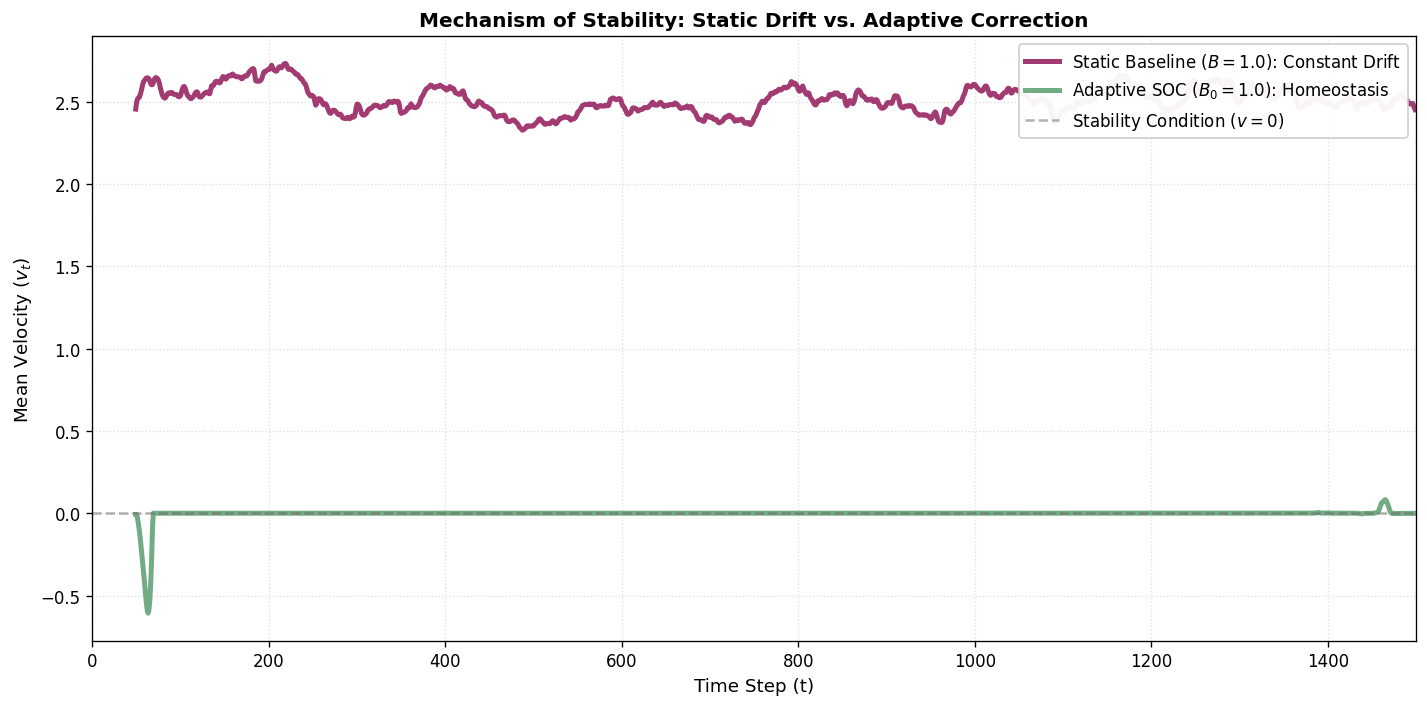

In [6]:
plot_velocity_trend_comparison()

In [7]:
def plot_system_breathing_dynamics():
    """
    Generates the 'Breathing' Plot (Phase Velocity Analysis).
    
    Visualizes the rate of change in network delay (velocity) to distinguish 
    between accumulation phases (stress) and recovery phases (relief).
    This highlights the oscillatory nature of the Myopic strategy.
    """
    print("Generating System Breathing Plot...")
    
    # Configuration: Select Myopic strategy (Beta=0) to visualize chaotic instability
    CURRENT_BETA = 0.0  
    
    # Run simulation (using the function defined previously)
    mean_delays, _, _ = simulate_supply_chain_dynamics(
        B_start=8.0, k=K, n=N_NODES, T=1000, T_start=0, 
        beta=CURRENT_BETA, alpha=ALPHA
    )

    # Calculate Velocity (First derivative of delay: v = D_t - D_{t-1})
    velocity_instant = np.diff(mean_delays)
    time_axis = np.arange(1, 1000)

    plt.figure(figsize=(14, 6), dpi=120)

    # --- 1. SEMANTIC ZONES ---
    # Red Zone: Positive velocity (Backlog is growing / Accumulation)
    plt.axhspan(0, np.max(velocity_instant), facecolor='#ffbfbf', alpha=0.2, 
                label='Accumulation Phase ($v > 0$)')
    
    # Green Zone: Negative velocity (Backlog is shrinking / Recovery)
    plt.axhspan(np.min(velocity_instant), 0, facecolor='#c7f9cc', alpha=0.3, 
                label='Recovery Phase ($v < 0$)')

    # --- 2. DATA PLOTTING ---
    plt.plot(time_axis, velocity_instant, color='#2E86AB', linewidth=1, alpha=0.7, 
             label='Instantaneous Velocity')
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

    # Trend Line (Moving Average)
    # Smooths out high-frequency noise to show the underlying oscillation cycle
    window = 15
    v_smooth = np.convolve(velocity_instant, np.ones(window)/window, mode='valid')
    # Align x-axis for valid convolution mode
    plt.plot(time_axis[window-1:], v_smooth, color='#0D3B66', linewidth=2.5, 
             label='Trend (Moving Avg)')

    # --- 3. ANNOTATION ---
    # Identify the point of maximum instability (highest accumulation rate)
    peak_idx = np.argmax(velocity_instant)
    peak_x = time_axis[peak_idx]
    peak_y = velocity_instant[peak_idx]   

    # Formatting
    plt.title(f"System Breathing: Phase Velocity Analysis (Myopic Agent, $\\beta={CURRENT_BETA}$)", 
              fontsize=12, fontweight='bold')
    plt.xlabel("Time Step (t)", fontsize=11)
    plt.ylabel("Delay Velocity ($v_t = \Delta D_t$)", fontsize=11)
    plt.legend(loc='upper right', framealpha=0.95, fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.xlim(0, 1000)
    
    plt.tight_layout()
    plt.show()

Generating System Breathing Plot...


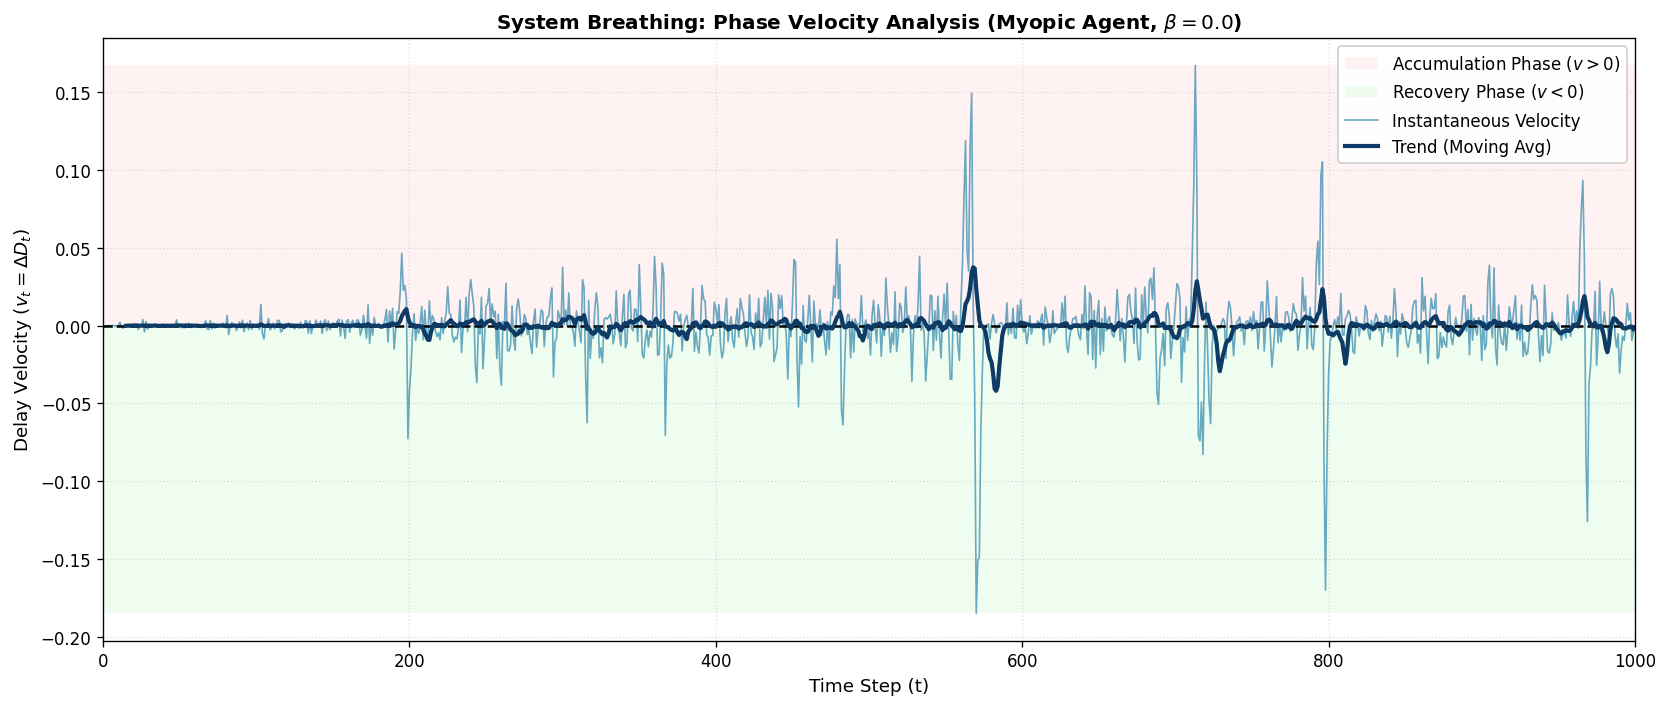

In [8]:
plot_system_breathing_dynamics()

In [9]:
def plot_efficiency_comparison():
    """
    Generates Plot A: Representative Run Comparison (Myopic vs. Wise).
    
    Visualizes the 'Efficiency Gap' between the two strategies under identical 
    stochastic conditions. 
    - Myopic agents (Beta=0) overreact, maintaining a high buffer to avoid stockouts.
    - Wise agents (Beta=1) trust the pipeline, maintaining a buffer near the 
      theoretical minimum (Bc) without crashing.
    """
    print("Generating Efficiency Comparison Plot...")
    
    # --- VISUALIZATION PARAMETERS ---
    # Start from a critical state to force immediate reaction
    B_START_VIS = 2.0   
    # Slightly higher decay rate to visualize dynamic adjustments clearly
    EPSILON_VIS = 0.05
    
    # --- 1. SIMULATION: MYOPIC STRATEGY ---
    # Reset seed to 42 to ensure the exact same demand sequence
    np.random.seed(42) 
    _, b_myopic, _ = simulate_supply_chain_dynamics(
        B_start=B_START_VIS, k=K, n=N_NODES, T=T_STEPS, T_start=0, 
        beta=BETA_MYOPIC, alpha=ALPHA, epsilon=EPSILON_VIS, pipeline_len=PIPELINE_LEN
    )
    
    # --- 2. SIMULATION: WISE STRATEGY ---
    # Reset seed to 42 again. This guarantees 'ceteris paribus' comparison.
    np.random.seed(42) 
    _, b_wise, _ = simulate_supply_chain_dynamics(
        B_start=B_START_VIS, k=K, n=N_NODES, T=T_STEPS, T_start=0, 
        beta=BETA_WISE, alpha=ALPHA, epsilon=EPSILON_VIS, pipeline_len=PIPELINE_LEN
    )
    
    # --- VISUALIZATION ---
    plt.figure(figsize=(12, 6), dpi=120)
    
    # Time axis
    time_steps = np.arange(T_STEPS)
    
    # 1. THE EFFICIENCY GAP (Shaded Region)
    # Highlights the excess inventory held by myopic agents
    plt.fill_between(time_steps, b_myopic, b_wise, 
                     where=(b_myopic > b_wise), 
                     color=COLORS['MYOPIC'], alpha=0.15, 
                     label='Wasted Resources (Inefficiency Gap)')
    
    # 2. DYNAMICS LINES
    plt.plot(b_myopic, color=COLORS['MYOPIC'], linewidth=1.5, alpha=0.9, 
             label='Myopic Strategy (No Pipeline Awareness)')
    plt.plot(b_wise, color=COLORS['WISE'], linewidth=2.5, alpha=0.9, 
             label='Wise Strategy (Pipeline Compensated)')
    
    # 3. THEORETICAL THRESHOLD
    plt.axhline(BC_THEO, color=COLORS['THEORY'], linestyle='--', linewidth=2.0, 
                label=f'Theoretical Critical Threshold ($B_c \\approx {BC_THEO:.2f}$)')
    
    # 4. ANNOTATION
    # Point out the specific behavior difference
    mid_point = T_STEPS // 2
    gap_size = b_myopic[mid_point] - b_wise[mid_point]
    plt.annotate('Over-reaction leads to\nexcess inventory (Bullwhip Effect)', 
                 xy=(mid_point, b_myopic[mid_point]), 
                 xytext=(mid_point + 100, b_myopic[mid_point] + 1.5),
                 arrowprops=dict(arrowstyle='->', color=COLORS['MYOPIC']),
                 fontsize=10, color=COLORS['MYOPIC'], fontweight='bold')

    # Formatting
    plt.title("Impact of Pipeline Awareness on Inventory Efficiency", fontsize=12, fontweight='bold')
    plt.xlabel("Time Step (t)", fontsize=11)
    plt.ylabel("Mean Buffer Size ($B_t$)", fontsize=11)
    plt.legend(fontsize=10, loc='upper right', framealpha=0.95)
    plt.grid(True, alpha=0.3, color=COLORS['GRID'])
    plt.xlim(0, T_STEPS)
    plt.ylim(0, max(b_myopic) * 1.2) # Add some headroom
    
    plt.tight_layout()
    plt.show()

Generating Efficiency Comparison Plot...


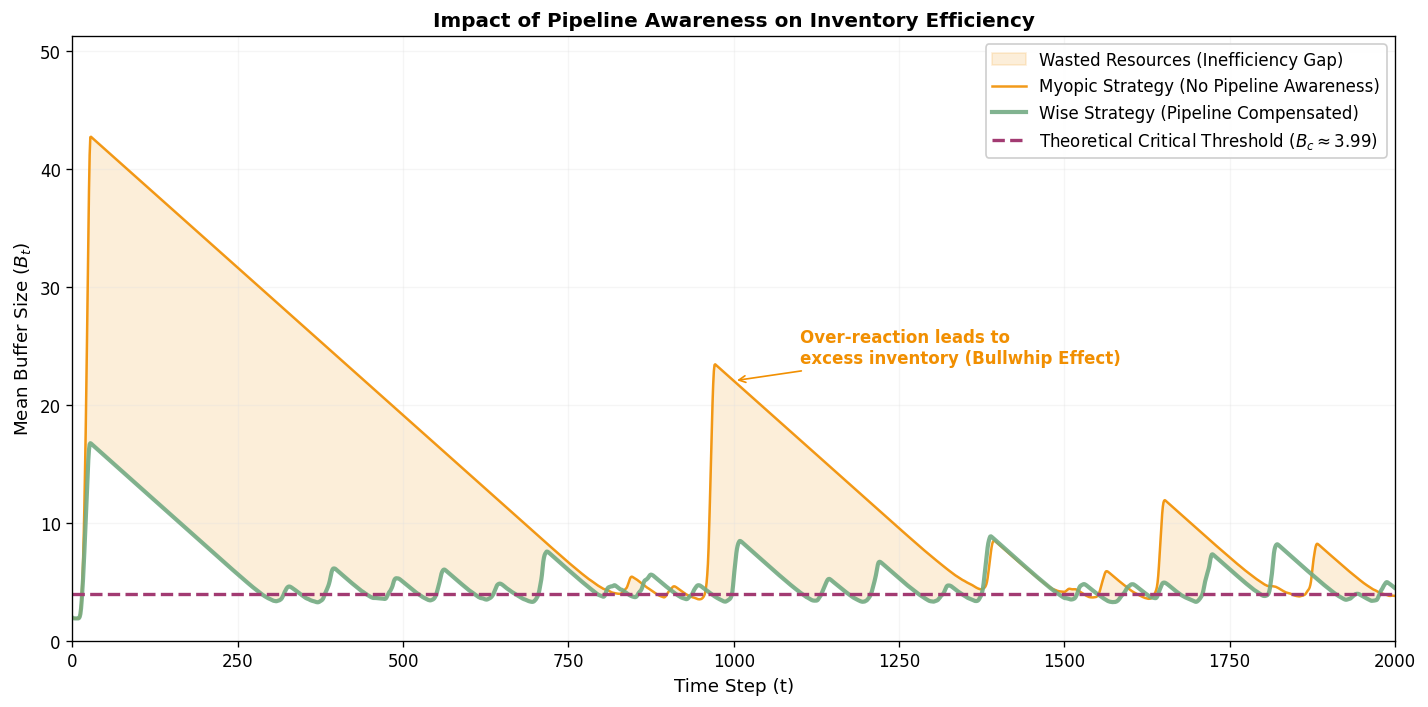

In [10]:
plot_efficiency_comparison()

In [11]:
def plot_phase_diagram_robustness():
    """
    Generates the Phase Diagram (Sensitivity Analysis).
    
    Explores the 'Control Space' defined by two competing parameters:
    1. Reaction Strength (Alpha): Aggressiveness of ordering logic.
    2. Efficiency Pressure (Epsilon): Aggressiveness of inventory reduction.
    
    Visualizes the resulting Mean Buffer Size to identify the stable operating 
    region ('Goldilocks Zone') versus extremes (Hoarding vs. Starvation).
    """
    print("Generating Phase Diagram: Robustness Analysis...")

    # --- PHASE SPACE PARAMETERS ---
    alphas = np.linspace(0.1, 1.0, 25)      # Y-axis: Reactivity
    epsilons = np.linspace(0.01, 0.2, 25)   # X-axis: Efficiency
    
    phase_grid = np.zeros((len(alphas), len(epsilons)))
    
    # Simulation Constraints (Reduced for Grid Search efficiency)
    N = 100 
    T = 600 
    B_INIT = 2.0
    PIPELINE_LEN = 5
    
    # --- GRID SEARCH ---
    print(f"Simulating {len(alphas)*len(epsilons)} parameter combinations...")
    
    for i, alpha in enumerate(alphas):
        for j, epsilon in enumerate(epsilons):
            
            # Initialization
            buffers = np.full(N, B_INIT)
            supply_pipeline = np.zeros((N, PIPELINE_LEN)) 
            
            avg_buffer_sum = 0
            count = 0
            
            # Fast Simulation Loop (Vectorized Wise Agent)
            np.random.seed(42) # Consistent stochasticity
            
            for t in range(T):
                # 1. Physics: Goods Arrival
                buffers += supply_pipeline[:, 0]
                supply_pipeline[:, :-1] = supply_pipeline[:, 1:]
                supply_pipeline[:, -1] = 0
                
                # 2. Demand Generation (Mean Field Proxy)
                # Simulates external stochastic load on the node
                load = np.random.exponential(scale=1.0, size=N)
                
                # State Calculation
                delay = np.maximum(0, load - buffers)
                
                # 3. Control Logic (Wise Agent, Beta=1.0)
                pending = np.sum(supply_pipeline, axis=1)
                perceived_gap = delay - pending
                
                # 4. Action Selection
                # Regime A: Ordering (Gap > 0)
                act_order = (delay > 1e-3) & (perceived_gap > 0)
                
                orders = np.zeros(N)
                orders[act_order] = alpha * perceived_gap[act_order] 
                supply_pipeline[act_order, -1] = orders[act_order]
                
                # Regime B: Optimization (No Delay)
                # Apply efficiency pressure to reduce inventory
                act_decay = ~act_order
                buffers[act_decay] = np.maximum(0, buffers[act_decay] - epsilon) 
                
                # Metric Collection (Steady State)
                if t > T - 150:
                    avg_buffer_sum += np.mean(buffers)
                    count += 1
            
            phase_grid[i, j] = avg_buffer_sum / max(1, count)

    # --- VISUALIZATION ---
    plt.figure(figsize=(10, 8), dpi=120)
    
    # Heatmap
    # Red = High Inventory (Hoarding), Green = Low Inventory (Minimalist)
    im = plt.imshow(phase_grid, origin='lower', aspect='auto', cmap='RdYlGn_r',
               extent=[epsilons.min(), epsilons.max(), alphas.min(), alphas.max()])
    
    cbar = plt.colorbar(im)
    cbar.set_label("Mean Buffer Size [Units]", fontsize=11)
    
    # Axes and Title
    plt.xlabel(r"Efficiency Pressure ($\epsilon$)", fontsize=12)
    plt.ylabel(r"Reaction Strength ($\alpha$)", fontsize=12)
    plt.title("Phase Diagram: The Three Zones of Control", fontsize=14, fontweight='bold', pad=15)
    
    # --- ANNOTATIONS ---
    # Common style for text boxes
    box_style = dict(facecolor='white', alpha=0.85, edgecolor='#dddddd', boxstyle='round,pad=0.5')
    text_args = dict(fontsize=10, fontweight='bold', zorder=10)

    # 1. THE HOARDER (High Alpha, Low Epsilon)
    # Result: Massive inventory accumulation due to over-reaction and low disposal.
    plt.text(epsilons.min() + 0.01, alphas.max() - 0.05, 
             "THE HOARDER\n(High Cost)", 
             color='#8B0000', ha='left', va='top', bbox=box_style, **text_args)

    # 2. THE MINIMALIST (Low Alpha, High Epsilon)
    # Result: Lean inventory, but high risk of stockouts (instability boundary).
    plt.text(epsilons.max() - 0.01, alphas.min() + 0.05, 
             "THE MINIMALIST\n(High Risk)", 
             color='#006400', ha='right', va='bottom', bbox=box_style, **text_args)

    # 3. THE GOLDILOCKS ZONE (Balanced)
    # Result: Optimal trade-off between stability and cost.
    plt.text(np.mean(epsilons), np.mean(alphas), 
             "GOLDILOCKS ZONE\n(Robust Stability)", 
             color='#333333', ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.6'), 
             fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

Generating Phase Diagram: Robustness Analysis...
Simulating 625 parameter combinations...


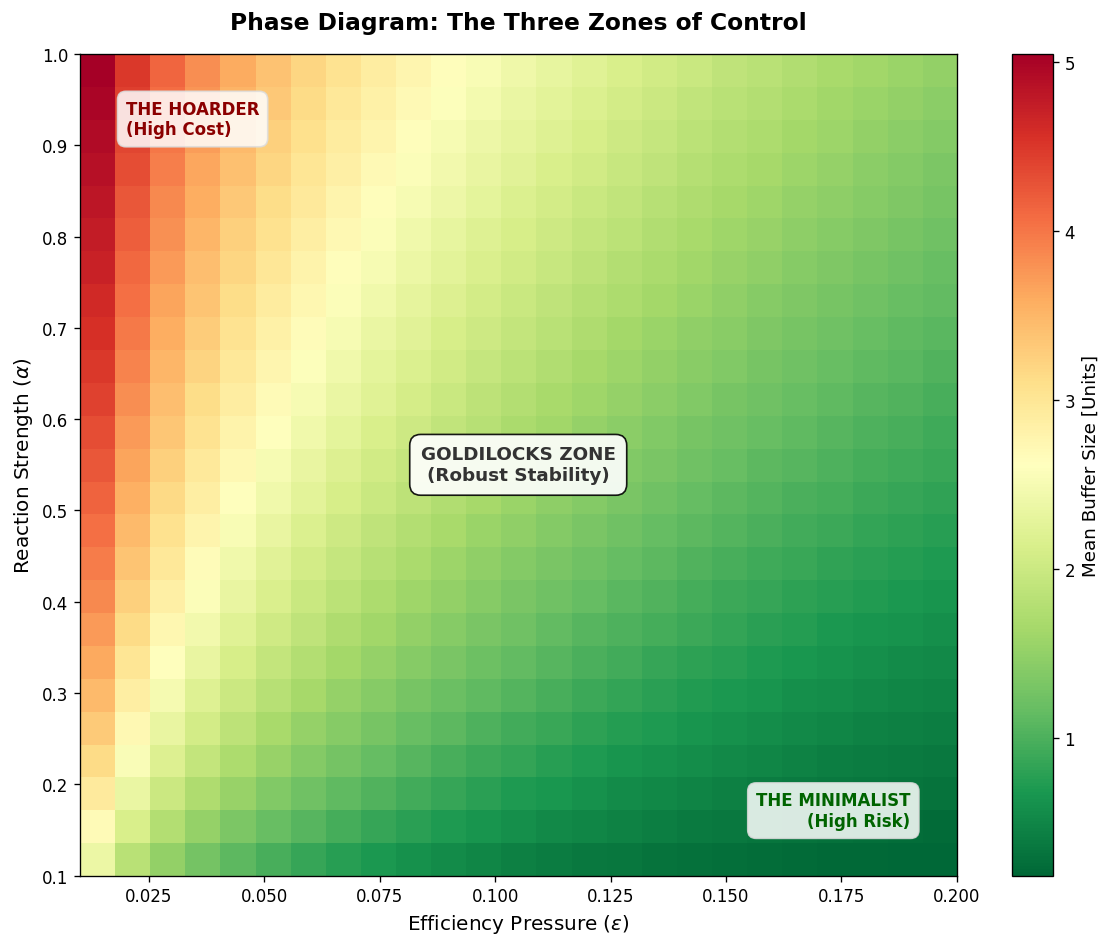

In [12]:
plot_phase_diagram_robustness()

In [13]:
def plot_time_evolution_zones():
    """
    Simulates and visualizes the time evolution of the three distinct control regimes.
    
    1. The Hoarder: High reactivity, low efficiency pressure -> Unbounded accumulation.
    2. The Minimalist: Low reactivity, high efficiency pressure -> System collapse (zero buffer).
    3. The Goldilocks Zone (SOC): Balanced parameters -> Self-organized stability.
    """
    print("Generating Time Evolution of Control Zones...")

    # --- 1. SIMULATION ENGINE ---
    def simulate_regime(T, N, alpha, epsilon):
        """Runs a simplified STN simulation for a specific parameter set."""
        buffers = np.full(N, 2.0)
        supply_pipeline = np.zeros((N, 5)) 
        buffer_history = []
        
        np.random.seed(42) # Fixed seed for reproducibility

        for t in range(T):
            # Physical Update (Goods arrival)
            buffers += supply_pipeline[:, 0]
            supply_pipeline[:, :-1] = supply_pipeline[:, 1:]
            supply_pipeline[:, -1] = 0

            # Demand and Delay
            demand = np.random.exponential(scale=1.0, size=N)
            delay = np.maximum(0, demand - buffers)
            
            # Control Logic (Wise Agent Beta=1.0 assumption)
            pending = np.sum(supply_pipeline, axis=1)
            gap = delay - pending
            
            # Action: Ordering (Driving Force)
            needs_order = (delay > 1e-3) & (gap > 0)
            orders = np.zeros(N)
            orders[needs_order] = alpha * gap[needs_order]
            supply_pipeline[needs_order, -1] = orders[needs_order]
            
            # Action: Optimization (Dissipative Force)
            buffers[~needs_order] = np.maximum(0, buffers[~needs_order] - epsilon)
            
            buffer_history.append(np.mean(buffers))
            
        return buffer_history

    # --- 2. EXECUTION ---
    T_STEPS = 500
    N_NODES = 100

    # Simulate the three archetypes
    hist_hoarder = simulate_regime(T_STEPS, N_NODES, alpha=0.8, epsilon=0.0)
    hist_minimalist = simulate_regime(T_STEPS, N_NODES, alpha=0.1, epsilon=0.5)
    hist_soc = simulate_regime(T_STEPS, N_NODES, alpha=0.5, epsilon=0.08)

    # --- 3. VISUALIZATION ---
    # Color Palette matches Phase Diagram
    c_hoarder = '#d62728'     # Red
    c_minimalist = '#006400'  # Dark Green
    c_goldilocks = '#8CBF26'  # Chartreuse/Lime (SOC)

    plt.figure(figsize=(12, 6), dpi=120)

    # Plot Lines
    plt.plot(hist_hoarder, color=c_hoarder, linewidth=2, alpha=0.8, 
             label='The Hoarder (High Cost)')
    plt.plot(hist_minimalist, color=c_minimalist, linewidth=2, alpha=0.8, 
             label='The Minimalist (High Risk)')
    plt.plot(hist_soc, color=c_goldilocks, linewidth=3, 
             label='The Goldilocks Zone (Stable)')

    # Styling
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title("Temporal Evolution of Control Regimes", fontsize=14, fontweight='bold', pad=10)
    plt.ylabel("Mean Buffer Size [Units]", fontsize=12)
    plt.xlabel("Time Step (t)", fontsize=12)
    plt.legend(fontsize=10, loc='upper left', framealpha=0.95)
    plt.grid(True, alpha=0.3, linestyle='--')

    # --- 4. DYNAMIC ANNOTATIONS ---
    # Labels are positioned relative to the final value of the simulation
    box_style = dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.4')
    x_pos = T_STEPS * 0.7  # Position text at 70% of the timeline

    # Tag: Hoarder
    y_pos_hoarder = hist_hoarder[-1] 
    plt.text(x_pos, y_pos_hoarder - 1.5, 'THE HOARDER\n(Over-reactive accumulation)', 
             color=c_hoarder, fontweight='bold', fontsize=10, bbox=box_style, ha='center')

    # Tag: Minimalist
    y_pos_minimalist = hist_minimalist[-1]
    plt.text(x_pos, y_pos_minimalist + 0.5, 'THE MINIMALIST\n(Collapse to zero)', 
             color=c_minimalist, fontweight='bold', fontsize=10, bbox=box_style, ha='center')

    # Tag: Goldilocks
    y_pos_soc = hist_soc[-1]
    plt.text(x_pos, y_pos_soc + 0.8, 'GOLDILOCKS ZONE\n(Self-Organized Stability)', 
             color='#4a6b13', fontweight='bold', fontsize=10, bbox=box_style, ha='center')

    plt.tight_layout()
    plt.show()

Generating Time Evolution of Control Zones...


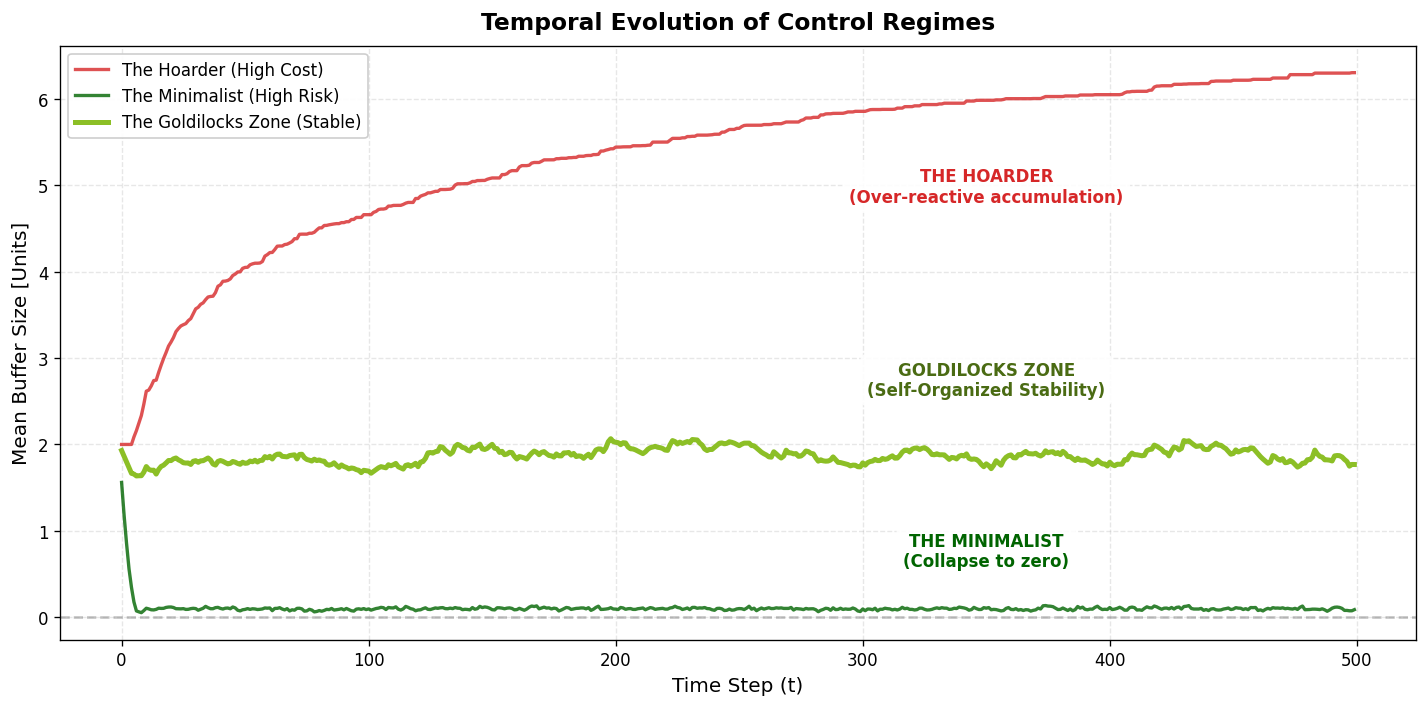

In [14]:
plot_time_evolution_zones()

In [15]:
# --- 1. TOPOLOGY GENERATION ---

def generate_ring_topology(n, k):
    """Generates a 1D Regular Ring Lattice (Strict Locality)."""
    neighbors = np.zeros((n, k), dtype=int)
    for i in range(n):
        offsets = [-2, -1, 1, 2, 3] # Adjust based on K=5
        for j, offset in enumerate(offsets):
            neighbors[i, j] = (i + offset) % n
    return neighbors

def generate_random_k_regular_topology(n, k):
    """Generates a Random k-Regular Directed Graph (Global Constraint)."""
    sources = np.repeat(np.arange(n), k)
    targets = np.repeat(np.arange(n), k)
    np.random.shuffle(targets)
    neighbors = targets.reshape((n, k))
    return neighbors

# --- 2. CORE SIMULATION ENGINE ---

def run_fixed_topology_simulation(topology_neighbors, n, T, T_start):
    """Executes the SOC simulation on a defined, static topology."""
    supply_pipeline = np.zeros((n, PIPELINE_LEN))
    buffers = np.full(n, B_INIT)
    delays_last = np.zeros(n)
    history_buffers = []
    
    np.random.seed(42) 
    
    for t in range(T):
        arriving_goods = supply_pipeline[:, 0]
        buffers = np.maximum(0, buffers + arriving_goods)
        supply_pipeline[:, :-1] = supply_pipeline[:, 1:] 
        supply_pipeline[:, -1] = 0.0
        
        noise = scipy.stats.expon.rvs(scale=NOISE_SCALE, size=n)
        neighbor_delays = delays_last[topology_neighbors]
        total_load = np.max(neighbor_delays, axis=1) + noise
        curr_delay = np.maximum(0, total_load - buffers)
        is_delayed = curr_delay > 1e-3
        
        pending_orders = np.sum(supply_pipeline, axis=1)
        perceived_gap = curr_delay - (BETA_WISE * pending_orders)
        
        new_orders = np.zeros(n)
        needs_order = (is_delayed) & (perceived_gap > 0)
        new_orders[needs_order] = ALPHA * perceived_gap[needs_order]
        supply_pipeline[needs_order, -1] = new_orders[needs_order]
        
        buffers[~is_delayed] = np.maximum(0, buffers[~is_delayed] - EPSILON)
        delays_last = curr_delay
        
        if t >= T_start:
            history_buffers.append(buffers.copy())
            
    return np.array(history_buffers).T

# --- 3. SPLIT VISUALIZATION FUNCTIONS ---

def plot_separate_heatmaps():
    print("Generating Separate Spatiotemporal Heatmaps...")
    
    N_VIS = 200 
    T_VIS = 1000
    T_START_VIS = 200
    
    # --- FIGURE 1: RING TOPOLOGY ---
    topo_ring = generate_ring_topology(N_VIS, K)
    hist_ring = run_fixed_topology_simulation(topo_ring, N_VIS, T_VIS, T_START_VIS)
    
    plt.figure(figsize=(10, 6), dpi=120)
    plt.imshow(hist_ring, aspect='auto', cmap='magma', interpolation='nearest', 
               vmin=0, vmax=np.percentile(hist_ring, 98))
    
    cbar = plt.colorbar()
    cbar.set_label("Buffer Stock ($B_i$)", fontsize=11)
    
    plt.title(f"Ring Lattice: Strict Locality Constraint\n(Nearest Neighbors, $K={K}$)", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Time Steps (Relative)", fontsize=12)
    plt.ylabel("Node Index (Geometric Order)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # --- FIGURE 2: RANDOM TOPOLOGY ---
    topo_random = generate_random_k_regular_topology(N_VIS, K)
    hist_random = run_fixed_topology_simulation(topo_random, N_VIS, T_VIS, T_START_VIS)
    
    # RCM Sorting
    data = np.ones(N_VIS * K)
    rows = np.repeat(np.arange(N_VIS), K)
    cols = topo_random.flatten()
    adjacency = csr_matrix((data, (rows, cols)), shape=(N_VIS, N_VIS))
    perm = reverse_cuthill_mckee(adjacency + adjacency.T)
    hist_random_sorted = hist_random[perm, :]
    
    plt.figure(figsize=(10, 6), dpi=120)
    plt.imshow(hist_random_sorted, aspect='auto', cmap='viridis', interpolation='nearest',
               vmin=0, vmax=np.percentile(hist_random_sorted, 98))
    
    cbar = plt.colorbar()
    cbar.set_label("Buffer Stock ($B_i$)", fontsize=11)
    
    plt.title(f"Random $k$-Regular: Global Degree Constraint\n($k_{{in}}=k_{{out}}={K}$, RCM Sorted)", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Time Steps (Relative)", fontsize=12)
    plt.ylabel("Node Index (Topological Order)", fontsize=12)
    plt.tight_layout()
    plt.show()


Generating Separate Spatiotemporal Heatmaps...


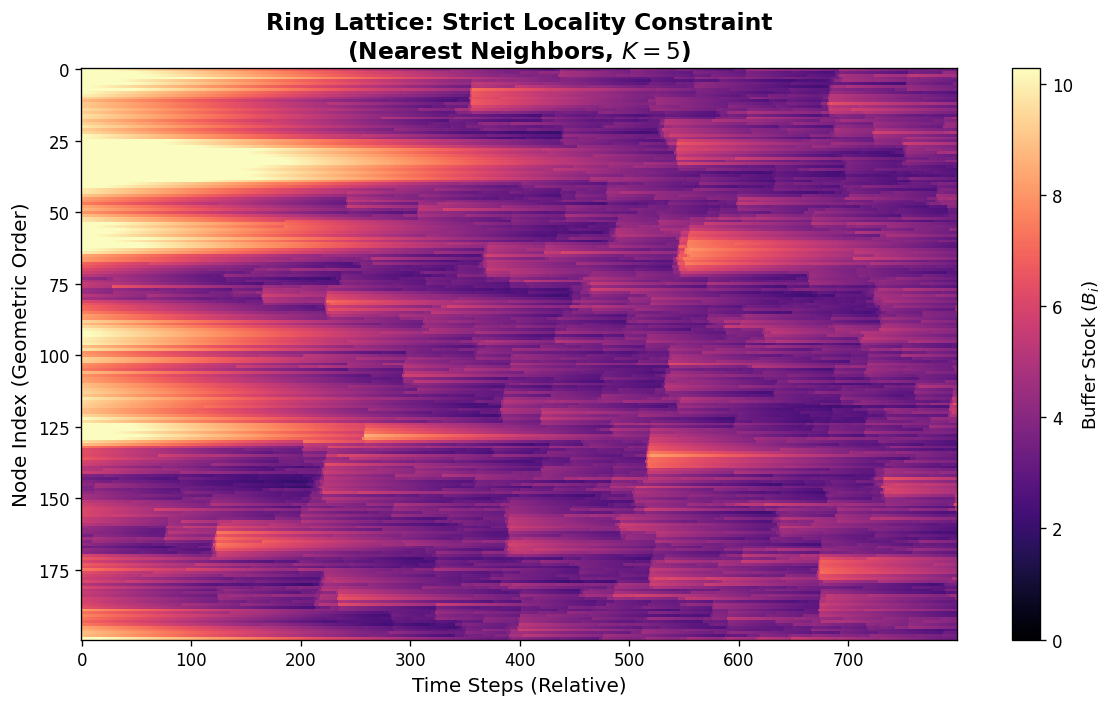

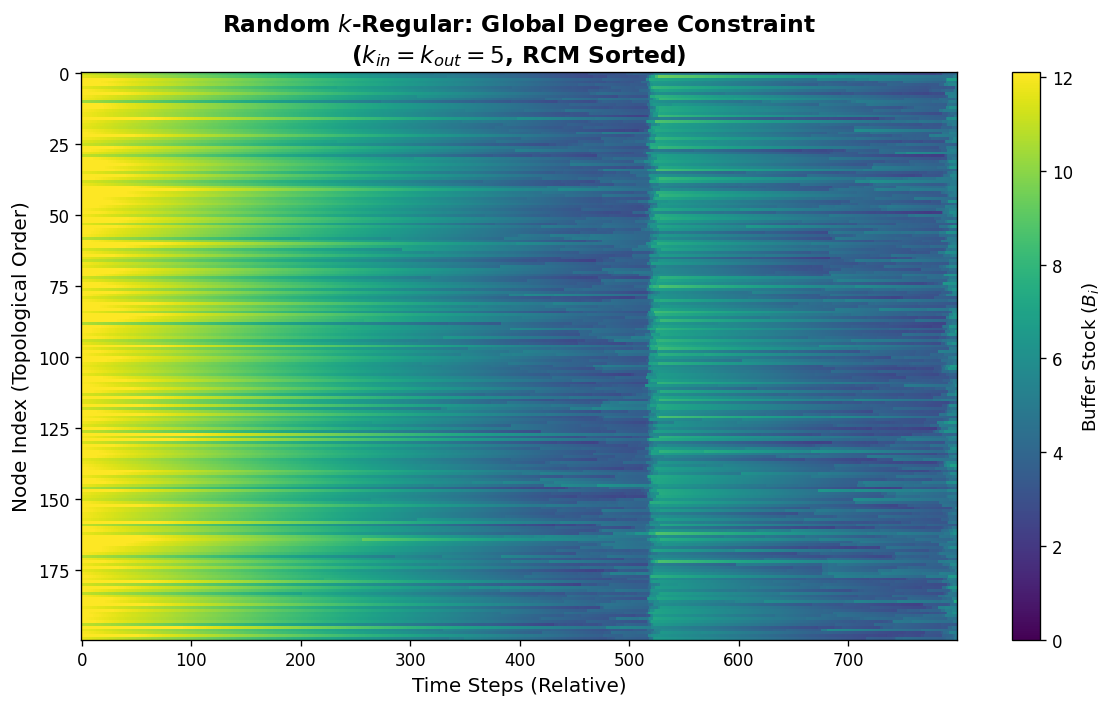

In [16]:
plot_separate_heatmaps()